# The Coffee Shop Mystery Part C: Causal World

## Previously in our Coffee Shop saga...

Our heroes discovered that basic statistical tools weren't enough to crack the case of *Café Chaos*'s sales mystery. The correlation analysis showed relationships, but couldn't tell what was causing what. Linear regression tried its best but left too many questions unanswered.



## Investigation Continues...
![Anime Scene 3](anime/C_anim/c_main.png)

"Okay," Mira says, pulling up a new notebook on her laptop. "Time to break out the big guns."

"Please tell me it doesn't involve more math," Jazz groans while wiping down the espresso machine.

"Oh, it involves *way* more math," Mira grins. "But don't worry - I'll explain everything using coffee analogies."

Max peers at the screen. "What are those weird terms? 'Instrumental Variables'? 'Double Machine Learning'? Sounds like sci-fi."

"Think of them as our secret weapons," Mira explains. "When simple tools aren't enough, you need something more sophisticated. Like how you upgraded from a basic coffee grinder to that fancy burr grinder with 40 different settings."

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# Add the src directory to path for imports
src_dir = os.path.join(os.path.dirname(os.getcwd()), 'src')
sys.path.append(src_dir)

from data_generator import DataGenerator
from causal_analysis import CausalAnalyzer


# Set up our analytical tools
sns.set_style("whitegrid")

# Get our café data and analyzer ready
generator = DataGenerator(seed=42)
data = generator.generate_data(n_days=200, include_hidden=True)
analyzer = CausalAnalyzer()

2025-02-04 11:58:22,667 - causal_analysis - INFO - CausalAnalyzer initialized


## Secret Weapon #1: Instrumental Variables

"First up," Mira begins, "we have Instrumental Variables. Think of it like this: You want to know if foot traffic actually causes more sales. But maybe people are coming in *because* they see others buying coffee. It's like a chicken-and-egg problem."

"That's... actually a good point," Max muses. "I can never tell if people are here because it's busy, or if it's busy because people are here."

"Exactly! But what if we looked at something that affects foot traffic but doesn't directly affect sales? Like weather! Bad weather might keep people home, which means less foot traffic, which means less sales. But the weather itself isn't directly making people buy or not buy coffee."

Jazz nods slowly. "Like how I use the steam wand temperature to control milk texture, but it's the texture that actually affects the latte art?"

"Perfect analogy! Let's try it out."

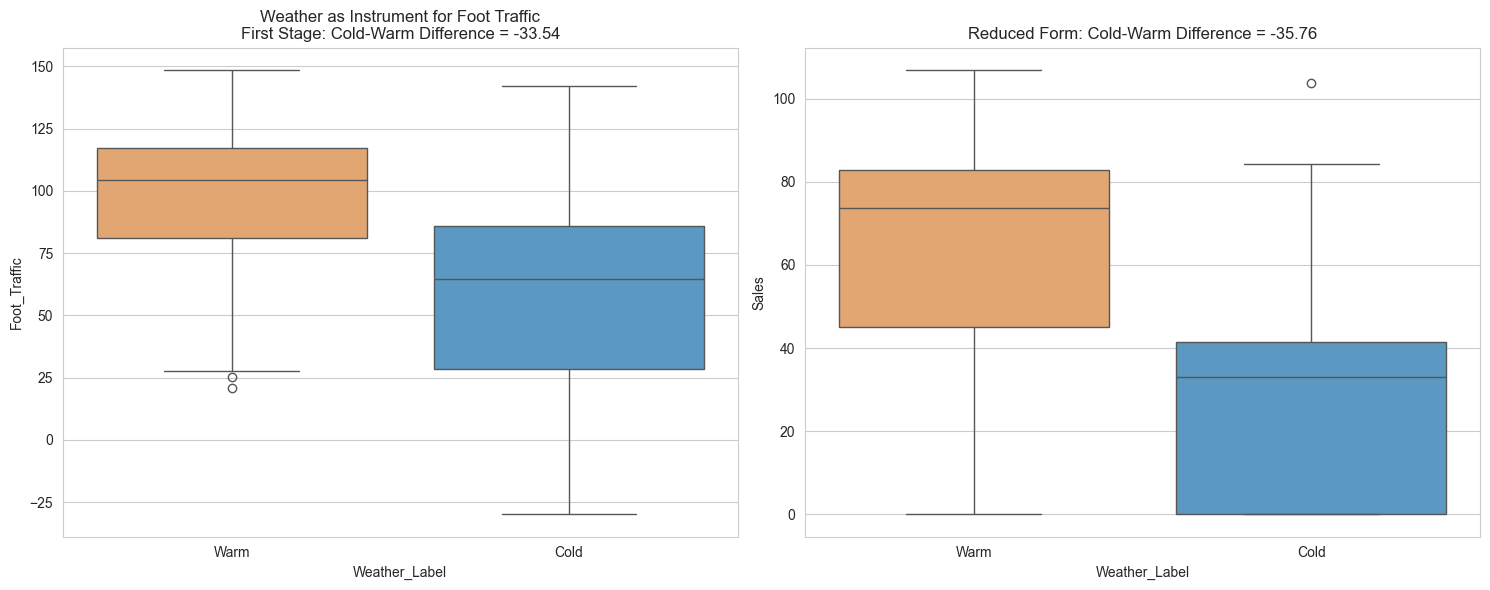


Results for Weather as Instrument for Foot Traffic:
IV Effect: 1.0661 (SE: 0.1987)
95% CI: [0.6767, 1.4556]
Cold-to-Warm Difference:
- First Stage: -33.5420
- Reduced Form: -35.7606
--------------------------------------------------


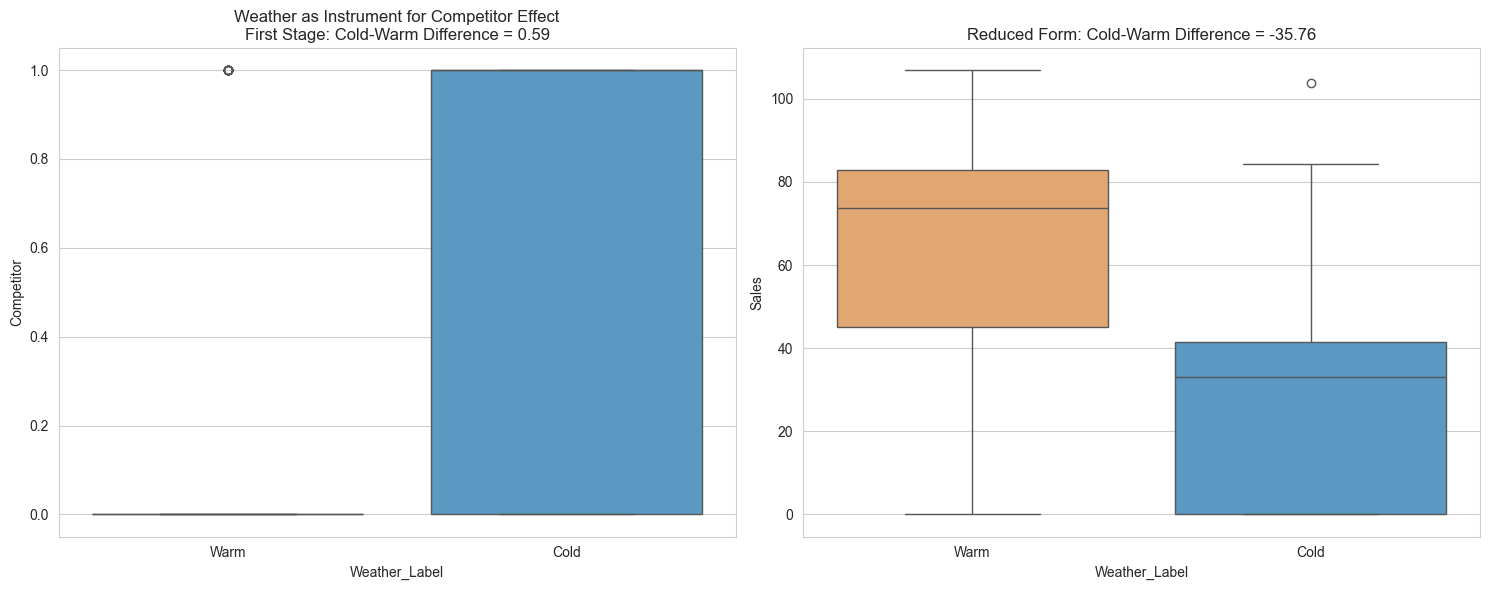


Results for Weather as Instrument for Competitor Effect:
IV Effect: -60.5623 (SE: 9.4879)
95% CI: [-79.1585, -41.9661]
Cold-to-Warm Difference:
- First Stage: 0.5905
- Reduced Form: -35.7606
--------------------------------------------------


In [2]:

def analyze_weather_iv(data, outcome, treatment, instrument):
    """Perform IV analysis with weather instrument"""
    # First stage: E[D|Z=Warm] - E[D|Z=Cold]
    first_stage = data[data[instrument] == 1][treatment].mean() - \
                 data[data[instrument] == 0][treatment].mean()
    
    # Reduced form: E[Y|Z=Warm] - E[Y|Z=Cold]
    reduced_form = data[data[instrument] == 1][outcome].mean() - \
                  data[data[instrument] == 0][outcome].mean()
    
    # Wald estimator
    iv_effect = reduced_form / first_stage
    
    # Standard errors
    n_warm = (data[instrument] == 1).sum()
    n_cold = (data[instrument] == 0).sum()
    
    var_d_warm = data[data[instrument] == 1][treatment].var()
    var_d_cold = data[data[instrument] == 0][treatment].var()
    var_y_warm = data[data[instrument] == 1][outcome].var()
    var_y_cold = data[data[instrument] == 0][outcome].var()
    
    se_first = np.sqrt(var_d_warm/n_warm + var_d_cold/n_cold)
    se_reduced = np.sqrt(var_y_warm/n_warm + var_y_cold/n_cold)
    
    se_iv = np.sqrt((se_reduced**2 / first_stage**2) + 
                    (reduced_form**2 * se_first**2 / first_stage**4))
    
    results = {
        'iv_effect': iv_effect,
        'iv_std_error': se_iv,
        'first_stage_diff': first_stage,
        'reduced_form_diff': reduced_form,
        'ci_lower': iv_effect - 1.96 * se_iv,
        'ci_upper': iv_effect + 1.96 * se_iv
    }
    
    return results

def plot_weather_iv_relationships(data, instrument, treatment, outcome, title_prefix=""):
    """Create boxplot visualization with weather labels and colors"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Create weather labels mapping 
    data = data.copy()
    data['Weather_Label'] = data[instrument].map({1: 'Cold', 0: 'Warm'})
    
    # Color palette (now in correct order for mapping)
    colors = ['#F4A460', '#4B9CD3']  # First color (orange) for Warm(0), Second color (blue) for Cold(1)
    
    # First stage relationship
    sns.boxplot(data=data, x='Weather_Label', y=treatment, ax=ax1, 
               order=['Warm', 'Cold'], palette=colors)
    first_stage_diff = data[data[instrument] == 1][treatment].mean() - \
                      data[data[instrument] == 0][treatment].mean()
    ax1.set_title(f'{title_prefix}\nFirst Stage: Cold-Warm Difference = {first_stage_diff:.2f}')
    
    # Reduced form relationship
    sns.boxplot(data=data, x='Weather_Label', y=outcome, ax=ax2,
               order=['Warm', 'Cold'], palette=colors)
    reduced_form_diff = data[data[instrument] == 1][outcome].mean() - \
                       data[data[instrument] == 0][outcome].mean()
    ax2.set_title(f'Reduced Form: Cold-Warm Difference = {reduced_form_diff:.2f}')
    
    plt.tight_layout()
    return fig, (first_stage_diff, reduced_form_diff)

def run_weather_iv_analysis(data):
    """Run IV analysis with weather instrument"""
    iv_combinations = [
        {
            'outcome': 'Sales',
            'treatment': 'Foot_Traffic',
            'instrument': 'Weather',
            'title': 'Weather as Instrument for Foot Traffic'
        },
        {
            'outcome': 'Sales', 
            'treatment': 'Competitor',
            'instrument': 'Weather',
            'title': 'Weather as Instrument for Competitor Effect'
        }
    ]
    
    results = {}
    for combo in iv_combinations:
        # Create visualization
        fig, diffs = plot_weather_iv_relationships(
            data,
            combo['instrument'],
            combo['treatment'],
            combo['outcome'],
            title_prefix=combo['title']
        )
        
        # Run analysis
        iv_results = analyze_weather_iv(
            data,
            combo['outcome'],
            combo['treatment'],
            combo['instrument']
        )
        
        key = f"{combo['instrument']}__{combo['treatment']}"
        results[key] = iv_results
        
        plt.show()
        print(f"\nResults for {combo['title']}:")
        print(f"IV Effect: {iv_results['iv_effect']:.4f} (SE: {iv_results['iv_std_error']:.4f})")
        print(f"95% CI: [{iv_results['ci_lower']:.4f}, {iv_results['ci_upper']:.4f}]")
        print(f"Cold-to-Warm Difference:")
        print(f"- First Stage: {iv_results['first_stage_diff']:.4f}")
        print(f"- Reduced Form: {iv_results['reduced_form_diff']:.4f}")
        print("-" * 50)
    
    return results

# Run the analysis
weather_iv_results = run_weather_iv_analysis(data)

## Decoding the IV Results

Mira studies the output. "These numbers tell quite a story. Look at the weather's effects - when it's cold, foot traffic drops by about 34 people compared to warm days, and sales drop by about 36 units."

"Sounds bad," Max frowns.

"Yes, but here's where it gets interesting," Mira continues. "For every person change in foot traffic caused by weather, sales change by about 1.07 units - and we're very confident about this effect since the confidence interval is tight: between 0.68 and 1.46."

"But what about the competitor numbers?" Jazz asks.

"That's the real revelation. Cold weather makes competitors 59% more likely to be present. And when weather drives competitor presence, it has a massive impact - each competitor-presence unit caused by weather reduces sales by about 61 units! The confidence interval from -79 to -42 tells us this negative effect is very real."

"So the competitor is really hurting us on cold days?" Max looks worried.

Mira nods. "Exactly. But this suggests an opportunity - if we can find ways to differentiate ourselves when it's cold..."

"Deeper analysis?" Max guesses.

Mira grins. "Double Machine Learning will show us even more."

## Secret Weapon #2: Double Machine Learning

"Okay," Mira explains, "Double Machine Learning is like... imagine you're trying to perfect your espresso recipe. But instead of just adjusting one thing at a time, you have a super-smart robot that can test *all* the variables at once - grind size, water temperature, pressure, timing - and figure out exactly how each one affects the final shot."

"That actually sounds amazing," Jazz admits. "Where can I get one of those robots?"

"The robot is metaphorical," Mira laughs. "But the math is real. Let's see what it tells us about your sales."

2025-02-04 11:58:23,252 - causal_analysis - INFO - Fitting DML for Weather with statsmodels inference



Analyzing Weather's effect on Sales:


2025-02-04 11:58:23,646 - causal_analysis - INFO - ATE: Mean: -35.8400, Std: 7.7193
2025-02-04 11:58:23,650 - causal_analysis - INFO - 95% CI: [-44.7456, -26.9344]
2025-02-04 11:58:23,651 - causal_analysis - INFO - y_r2: -0.1179
2025-02-04 11:58:23,652 - causal_analysis - INFO - t_r2: -0.1122
2025-02-04 11:58:23,653 - causal_analysis - INFO - Fitting DML for Social_Media with statsmodels inference


- Direct Effect: -35.8400 (SE: 7.7193)
- 95% CI: [-44.7456, -26.9344]
- Model Quality: Y=-0.1179, T=-0.1122

Analyzing Social_Media's effect on Sales:


2025-02-04 11:58:24,005 - causal_analysis - INFO - ATE: Mean: 3.4973, Std: 3.8336
2025-02-04 11:58:24,005 - causal_analysis - INFO - 95% CI: [-0.3242, 7.3188]
2025-02-04 11:58:24,005 - causal_analysis - INFO - y_r2: 0.5571
2025-02-04 11:58:24,005 - causal_analysis - INFO - t_r2: -0.0284
2025-02-04 11:58:24,005 - causal_analysis - INFO - Fitting DML for Competitor with statsmodels inference


- Direct Effect: 3.4973 (SE: 3.8336)
- 95% CI: [-0.3242, 7.3188]
- Model Quality: Y=0.5571, T=-0.0284

Analyzing Competitor's effect on Sales:


2025-02-04 11:58:24,368 - causal_analysis - INFO - ATE: Mean: -45.3152, Std: 8.0110
2025-02-04 11:58:24,368 - causal_analysis - INFO - 95% CI: [-57.8157, -32.8148]
2025-02-04 11:58:24,368 - causal_analysis - INFO - y_r2: 0.2249
2025-02-04 11:58:24,368 - causal_analysis - INFO - t_r2: 0.2776


- Direct Effect: -45.3152 (SE: 8.0110)
- 95% CI: [-57.8157, -32.8148]
- Model Quality: Y=0.2249, T=0.2776


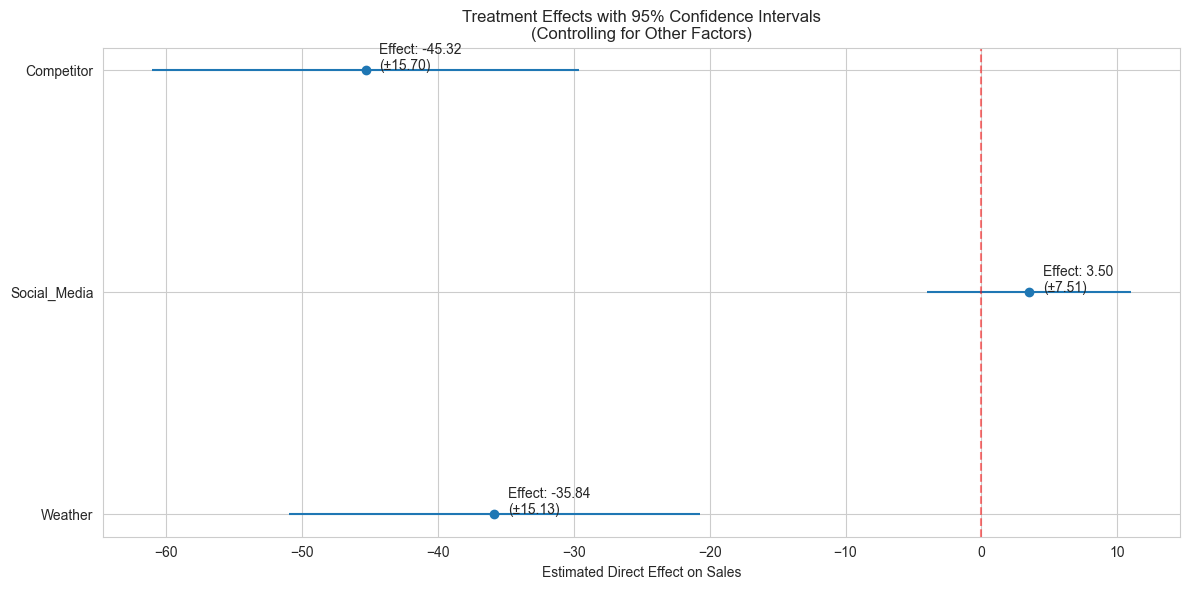

In [3]:


def run_dml_analysis(data, analyzer):
    """Run Double ML with proper feature selection and standardization"""
    # Define treatment-specific feature sets
    feature_sets = {
        'Weather': ['Social_Media'],
        'Social_Media': ['Weather', 'Competitor'],
        'Competitor': ['Weather', 'Social_Media']
    }
    
    # Initialize results storage
    results = {}
    effects = []
    errors = []
    labels = []
    
    # Standardize continuous variables
    scaler = StandardScaler()
    data_scaled = data.copy()
    data_scaled['Social_Media'] = scaler.fit_transform(data[['Social_Media']])
    
    for treatment in feature_sets.keys():
        print(f"\nAnalyzing {treatment}'s effect on Sales:")
        
        # Run DML with proper features
        result = analyzer.double_ml_analysis(
            df=data_scaled,
            treatment=treatment,
            outcome='Sales',
            features=feature_sets[treatment]
        )
        
        results[treatment] = result
        
        if result.get('success', False):
            print(f"- Direct Effect: {result['ate']:.4f} (SE: {result['ate_std']:.4f})")
            print(f"- 95% CI: [{result['ci_lower']:.4f}, {result['ci_upper']:.4f}]")
            if 'nuisance_scores' in result:
                print(f"- Model Quality: Y={result['nuisance_scores'].get('y_r2', 'NA'):.4f}, "
                      f"T={result['nuisance_scores'].get('t_r2', 'NA'):.4f}")
            
            effects.append(result['ate'])
            errors.append(result['ate_std'] * 1.96)
            labels.append(treatment)
            
    # Visualization
    plt.figure(figsize=(12, 6))
    y_pos = np.arange(len(labels))
    
    plt.errorbar(effects, y_pos, xerr=errors, fmt='o')
    plt.yticks(y_pos, labels)
    plt.xlabel('Estimated Direct Effect on Sales')
    plt.title('Treatment Effects with 95% Confidence Intervals\n(Controlling for Other Factors)')
    plt.axvline(x=0, color='red', linestyle='--', alpha=0.5)
    
    # Add effect size annotations
    for i, (effect, error) in enumerate(zip(effects, errors)):
        plt.annotate(f'Effect: {effect:.2f}\n(±{error:.2f})',
                    xy=(effect, i),
                    xytext=(10, 0), 
                    textcoords='offset points')
    
    plt.tight_layout()
    plt.show()
    
    return results

# Run the analysis
dml_results = run_dml_analysis(data, analyzer)

## So what does DML say?
Mira studies the DML results thoughtfully. "Now these numbers tell the real story."
"The competitor effect is brutal - each competitor presence directly reduces sales by about 45 units, plus or minus 16. That's a huge impact, and we're very confident about it since the confidence interval never crosses zero."

"What about the weather?" Max asks anxiously.

"Cold weather has a strong direct effect too - about 36 units lower sales compared to warm days. This is separate from how it affects foot traffic or brings competitors. The narrow confidence interval from -45 to -27 shows this effect is very reliable."

"And our social media efforts?"

"That's interesting - while social media shows a small positive effect of about 3.5 units, the confidence interval crosses zero (-0.3 to 7.3). This suggests it helps, but its impact isn't as clear-cut as the other factors."

"So what do we do?" Max looks worried.

Mira leans forward. "This tells us where to focus. The competitor is your biggest challenge, especially on cold days when they have a double advantage. But that also means..."

"That's where we can make the biggest difference?" Jazz suggests.

"Exactly! On cold days, when we know the competitor will be active, we need a strategy to stand out. The social media impact may be subtle, but combined with the right timing..."

"There's more to analyze?" Max guesses.

"Oh yes," Mira grins. "Wait until you see what Transfer Entropy reveals about these patterns over time."

---

**To be continued in Part D: From ML to Information Theory**

*(Will our heroes use their new insights to save Café Chaos? What new strategies will they develop based on these findings? And will Jazz finally admit that statistics might be as interesting as latte art? Stay tuned...)*